In [1]:
# load pre-trained glove embeddings
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# specify the loaction of the downloaded glove file
path_of_downloaded_files = "/home/cim/staff/uhac002/Library/Embeddings/GloVe/glove.6B.300d.txt"
# path_of_downloaded_files = "/Users/yg211/Embeddings/Glove/glove.6B.300d.txt"
glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [6]:
# then we define the attentive RNN-based classifier
import torch
import torch.nn as nn

class RNN_Attention(nn.Module):
    def __init__(self, embd_dim, hidden_dim, cls_num, gpu):
        super(RNN_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size=embd_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=False)
        self.softmax = nn.Softmax()
        self.fc = nn.Linear(hidden_dim, cls_num)
        self.query_vec = torch.randn(1,hidden_dim, requires_grad=True)
        self.gpu = gpu
        if gpu: 
            self.to('cuda')
            self.query_vec = self.query_vec.to('cuda')
    def weighted_sum_vector(self, hidden_states, weights):
        # we view the weighted summation of hidden states as a covolutional computation process
        # covolutional computation is very efficient to run
        aggregation_layer = torch.nn.Conv1d(in_channels=hidden_states.shape[0], out_channels=1, kernel_size=1, bias=False)
        if self.gpu: aggregation_layer.to('cuda')
        aggregation_layer.weight = torch.nn.Parameter(weights.unsqueeze(2))
        # print('weights', aggregation_layer.weight.shape)
        weighted_vec = aggregation_layer(hidden_states.unsqueeze(0))
        return weighted_vec
    def forward(self, input_matrix):
        hidden_states = self.lstm(input_matrix.unsqueeze(0))[0].squeeze()
        # print('len shape', len(hidden_states.shape))
        if len(hidden_states.shape) == 1: hidden_states = hidden_states.unsqueeze(0)
        # print('hidden states', hidden_states.shape)
        atten_logits = torch.mm(self.query_vec, torch.transpose(hidden_states,0,1))
        # print('atten logits', atten_logits.shape)
        atten_probs = self.softmax(atten_logits)
        weighted_vec = self.weighted_sum_vector(hidden_states, atten_probs)
        # print('weighted sum vec', weighted_vec.shape)
        logits = self.fc(weighted_vec)
        return logits, atten_probs

In [7]:
import pickle

saved_dic = pickle.load(open('sample_trained_model.pickle', 'rb'))
oov_vec = saved_dic['oov_vec']
embd_dim = saved_dic['embd_dim']
hidden_dim = saved_dic['hidden_dim']
cls_num = saved_dic['cls_num']
query_vec = saved_dic['query_vec']

In [8]:
gpu = False 
model = RNN_Attention(embd_dim, hidden_dim, cls_num, gpu)

if gpu:
    model.load_state_dict(torch.load('attentive_rnn_trained_model.state_dict'))
    model.query_vec = query_vec
else:
    model.load_state_dict(torch.load('attentive_rnn_trained_model.state_dict', map_location=lambda storage, loc: storage))
    model.query_vec = query_vec.cpu().detach()


import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import numpy as np


def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    return np.array(vecs)

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs.append(vv)
    # print('mini batch shape',np.array(text_vecs).shape)
    return np.array(text_vecs)

def predict_explain(sent, word_vectors, model, use_gpu=False):
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
        batch = build_mini_batch([sent], word_vectors)
        input_sent = torch.from_numpy(batch[0]).float()
        if use_gpu: input_sent = input_sent.to('cuda')
        logits, attentions = model(input_sent)
        softmax = nn.Softmax()
        probs = softmax(logits.squeeze()).cpu()
        print('probability pos: {:3f}, neg: {:3f}'.format(probs[0], probs[1]))
        words = word_tokenize(sent)
        attentions = list(attentions.squeeze().cpu().detach().numpy())
        print('attention values', attentions)
        assert len(words) == len(attentions)
        plt.bar(words, attentions)
        plt.show()

probability pos: 0.286933, neg: 0.713067
attention values [0.317649, 0.682351]


/home/cim/staff/uhac002/PycharmProjects/ScratchPad/venv_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/cim/staff/uhac002/PycharmProjects/ScratchPad/venv_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


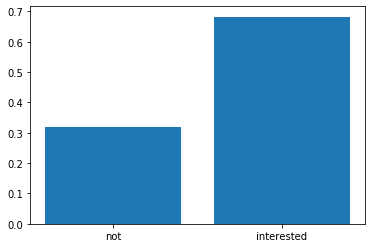

In [11]:
predict_explain(
    "not interested",
    word_vectors, model, gpu)